# Axelrod's Model of Social Norms and Meta-Norms

### Nathan Brei

### Technical University of Munich

We are going to start by defining our agent. In this particular simulation, the agent's behavior is going to be determined by two meme values, `boldness` and `viciousness`, as per Axelrod's paper [Axelrod, 1986]. Every time the agent interacts with its neighbors, their respective `payoff`s will be updated. These interactions are mediated via `isBad` and `visibility`, which describe whether the agent ultimately chose to defect and the probability that a  neighboring agent recognized it. After some number of interactions, the expected value of each agent's payoff will hopefully converge, and the agent can adjust its strategy (in other words, update boldness and viciousness) by looking at the strategies and payoffs of its neighbors.

Unlike Axelrod's original paper, this particular simulation takes spatial proximity into account. The agents 'live' on an abstract 2D grid and only interact with their immediate neighbors, like cellular automata.


In [1]:
type Agent
    
    boldness :: Float16
    viciousness :: Float16

    payoff :: Float16
    visibility :: Float16

    isBad :: Bool
    isMerciful :: Bool
    
    location :: Tuple{Int,Int}
end

We define a Landscape, which represents our 2D grid. We implement it as a plain 2D array, and use a type alias to avoid any unnecessary indirection. We make the following design decisions:

* The grid wraps around, giving us a torus topology, or periodic boundary conditions

* Every cell is occupied by exactly one agent. Note: we had other options:
    - Zero or one agents per cell:  `Nullable{Array{Agent, 2}}`
    - Zero or more agents per cell: `Array{Agent, 3}`
    
* Agents are immobile


The relationship between Agent and Landscape follows the array-of-structures pattern which is good for conceptual clarity. It is not so good for memory performance, so you could consider changing this to a structure-of-arrays. Remember that in Julia, a composite type such as Agent is a struct, not an object, and hence could be stored in-place. I have not yet verified that this is in fact the case. 

In [2]:
Landscape = Array{Agent, 2}

Array{Agent,2}

Now we want to create a new landscape filled with randomly generated agents. 
Although both Axelrod and Gaylord ch 5 ex 9 say we should represent our meme values as ints from 1..7, 
I'm using floats because I find it to be conceptually cleaner. 

In [3]:
function initialize_landscape(width::Int, height::Int)
    landscape = Landscape(height, width)
    for i = 1:height
        for j = 1:width
            landscape[i,j] = Agent(rand(), rand(), 0.0, 0.0, false, false, (i,j))
        end
    end
    return landscape :: Landscape
end

l = initialize_landscape(10, 10)

10×10 Array{Agent,2}:
 Agent(0.36255, 0.63965, 0.0, 0.0, false, false, (1, 1))  …  Agent(0.74951, 0.66846, 0.0, 0.0, false, false, (1, 10)) 
 Agent(0.44482, 0.38892, 0.0, 0.0, false, false, (2, 1))     Agent(0.40161, 0.20117, 0.0, 0.0, false, false, (2, 10)) 
 Agent(0.70117, 0.98975, 0.0, 0.0, false, false, (3, 1))     Agent(0.26733, 0.33325, 0.0, 0.0, false, false, (3, 10)) 
 Agent(0.20422, 0.44165, 0.0, 0.0, false, false, (4, 1))     Agent(0.60596, 0.6958, 0.0, 0.0, false, false, (4, 10))  
 Agent(0.37744, 0.6084, 0.0, 0.0, false, false, (5, 1))      Agent(0.78906, 0.22083, 0.0, 0.0, false, false, (5, 10)) 
 Agent(0.68945, 0.62354, 0.0, 0.0, false, false, (6, 1))  …  Agent(0.45557, 0.19507, 0.0, 0.0, false, false, (6, 10)) 
 Agent(0.62549, 0.38013, 0.0, 0.0, false, false, (7, 1))     Agent(0.83838, 0.21509, 0.0, 0.0, false, false, (7, 10)) 
 Agent(0.1947, 0.2439, 0.0, 0.0, false, false, (8, 1))       Agent(0.092468, 0.45703, 0.0, 0.0, false, false, (8, 10))
 Agent(0.34082, 0.48389, 0

We define a function which takes an Agent and returns a list of neighboring Agents. This is where we enforce the torus topology constraint. 

Since our agents can not move, this is the primary coupling to the Landscape implementation. We should have our transition functions call `neighbors()` and pretend that the Landscape data structure is abstract and opaque. This way, we can swap out different Landscape implementations with minimal code changes. (In a true object-oriented language we'd use encapsulation for this.) 

The compiler will heavily optimize the list comprehensions, I hope. 

In [4]:
function neighbors(agent::Agent, landscape::Landscape)
    r,c = agent.location
    r_max, c_max = size(landscape)
    offsets = [(dx,dy) for dx = -1:1, dy = -1:1 if !(dx==0 && dy==0)]
    coords = [((r+dy+r_max-1)%r_max + 1, (c+dx+c_max-1)%c_max + 1) for (dx,dy) = offsets]
    agents = [landscape[r,c] for (r,c) = coords]
    return agents :: Array{Agent,1}
end

neighbors (generic function with 1 method)

Let's quickly verify that `neighbors()` correctly wraps around. The [1,1] agent should be neighbors with blocks of agents in each corner.

In [5]:
[a.location for a = neighbors(l[1,1],l)]

8-element Array{Tuple{Int64,Int64},1}:
 (10, 10)
 (10, 1) 
 (10, 2) 
 (1, 10) 
 (1, 2)  
 (2, 10) 
 (2, 1)  
 (2, 2)  

We have created a large landscape but as of yet have no way to visualize it. Because our landscape implementation is so dead simple, we can generate a heatmap showing each of (boldness, viciousness, payoff) over the domain.


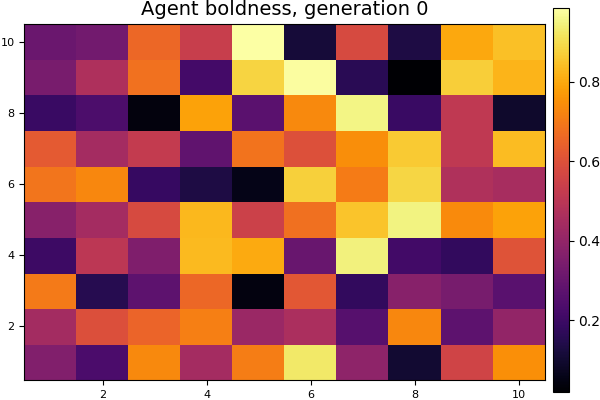

In [7]:
using Plots
pyplot()
boldnesses = map((agent) -> agent.boldness, l)
heatmap(boldnesses, title="Agent boldness, generation 0")

We model interactions between agents via the transition function `update_payoff`, which runs for each agent in two separate phases, `defect` and `punish`. The two separate phases are necessary because `punish` looks for defections among all neighbors; doing this in a single pass would pick up spurious defection data from the previous iteration.

A third phase, `metapunish`, is optional. This represents the more complicated case of a population enforcing its norms by also punishing anyone who is caught _not_ enforcing the norms. 

In [8]:
function update_payoff(landscape::Landscape, useMetaNorm=false)

    rows,cols = size(landscape)
    for i = 1:rows
        for j = 1:cols
            defect(landscape[i,j], landscape)
        end
    end        
    for i = 1:rows
        for j = 1:cols
            punish(landscape[i,j], landscape)
        end
    end
    if (useMetaNorm)
        for i = 1:rows
            for j = 1:cols
                metapunish(landscape[i,j], landscape)
            end
        end
    end
end

update_payoff (generic function with 2 methods)

In the first phase, each agent randomly generates its own likelihood of being caught, and decides whether or not to defect. If it does decide to defect, it gains some 'temptation' payoff and its neighbors lose some 'hurt' payoff. 

In [9]:
function defect(agent::Agent, landscape::Landscape, temptation=3, hurt=-1)
    
    agent.visibility = rand()
    if (agent.boldness < agent.visibility)
        agent.isBad = false
    else
        agent.isBad = true
        agent.payoff += temptation
        for neighbor = neighbors(agent, landscape)
            neighbor.payoff += hurt
        end
    end
end

defect (generic function with 3 methods)

This can be illustrated with a small test case. We create a 7x7 grid and constrain the agent at [3,3] to always defect. When we run the defection code for just that agent, we see that his own payoff has risen at the expense of his neighbors. 


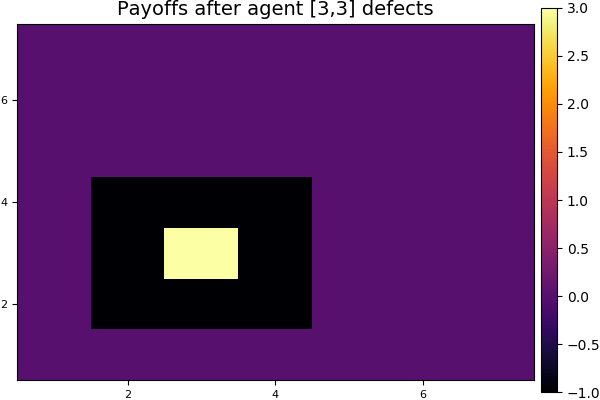

In [10]:
test = initialize_landscape(7, 7)
agent = test[3,3]
agent.boldness = 1
defect(agent, test)

using Plots
heatmap(map((a)->a.payoff, test), title="Payoffs after agent [3,3] defects")


In the second phase, each agent looks at all its neighbors, and doles out punishment when the following conditions are met:

- The neighbor chose to defect
- The agent 'sees' the defection (with a probability given by `neighbor.visibility`)
- The agent chooses to punish (with a probability given by `agent.viciousness`)

The agent must explicitly track whether it chose mercy so that this can be incorporated in the metapunishment model.

In [11]:
function punish(agent::Agent, landscape::Landscape, penalty=-9, enforcement=-2)

    for neighbor = neighbors(agent, landscape)
        
        agent.isMerciful = false
        if (neighbor.isBad && neighbor.visibility >= rand()) 
            # Agent catches neighbor defecting

            if (agent.viciousness >= rand()) 
                # Agent chooses to punish
                neighbor.payoff += penalty
                agent.payoff += enforcement                
            else 
                # Agent chooses mercy
                agent.isMerciful = true
            end            
        end
    end
end

punish (generic function with 3 methods)

This can be also be illustrated with a test case. Since we've constrained this up so that only agent [3,3] defected, each of his neighbors may punish only him or do nothing. Re-running this code snippet will reveal that the subset of neighbors who choose to punish is random. The merciful neighbors will stay at their original -1 payoff, the punishers will drop to -3 payoff, and the offending agent [3,3] will lose -9 for each punisher. This choice of payoffs leads to a dramatically lose-lose situation (a negative-sum game?) -- because one agent chose to defect, every agent involved has lost utility.


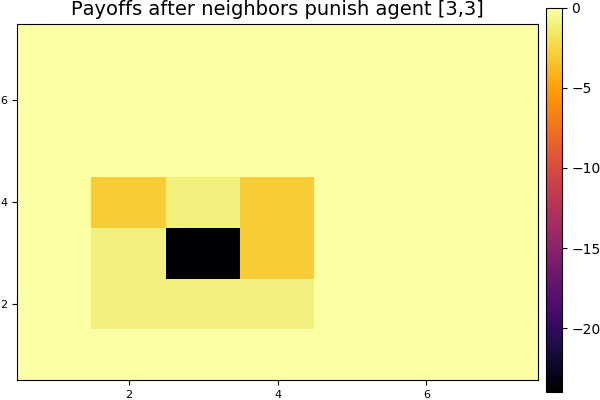

In [12]:
test = initialize_landscape(7, 7)
agent = test[3,3]
agent.boldness = 1
defect(agent, test)
for neighbor = neighbors(agent, test)
    punish(neighbor, test)
end

heatmap(map((a)->a.payoff, test), title="Payoffs after neighbors punish agent [3,3]")


The final phase of `update_payoff` is meta-punishment: The agents who chose not to punish (i.e. were not vicious enough) are themselves punished by their neighbors, albeit with a different penalty and enforcement cost. 

In [13]:
function metapunish(agent::Agent, landscape::Landscape, penalty=-3, enforcement=-1)

    for neighbor = neighbors(agent, landscape)
                
        if (neighbor.isMerciful &&              # Neighbor chose mercy
            neighbor.visibility >= rand() &&    # Agent detects merciful neighbor
            agent.viciousness >= rand())        # Agent chooses to punish
                    
            neighbor.payoff += penalty
            agent.payoff += enforcement
            
            # print("$(agent.location) is metapunishing $(neighbor.location)\n")
        end
    end
end

metapunish (generic function with 3 methods)

When we run `update_payoff` on a fresh landscape with randomly chosen strategies, the payoff distribution strongly resembles white noise. After multiple iterations, some agents accumulate strongly negative payoffs. The maximum payoff never seems to rise above 3. (Note: payoffs are summed, but never divided by the number of iterations; total payoff is used in place of expected payoff.)


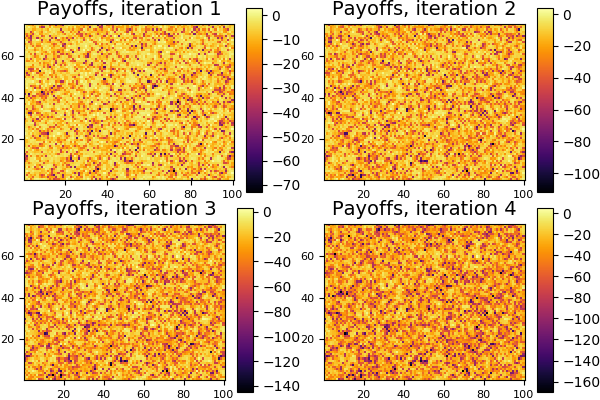

In [44]:
l = initialize_landscape(100, 75)
p = Array{Any,1}(4)
for i = 1:4
    update_payoff(l)
    p[i] = plot(heatmap(map((a)->a.payoff, l), title="Payoffs, iteration $i"))
end
plot(p..., layout=(2,2))

Now we introduce the evolutionary component. Once the expected payoffs are known, each agent may adjust their own strategy by examining the strategies and resultant payoffs of their neighbors. The mechanism for meme transfer is basic hill-climbing: Each agent takes a small step towards the strategy of its _best-performing_ neighbor.

A `mutations` parameter is also provided in case we want to restart some fraction of the agents with a random strategy. This helps the search algorithm escape local minima at the expense of convergence speed.

In [15]:
function update_strategy(landscape::Landscape, stepsize=0.5, mutations=0.0)
    rows,cols = size(landscape)
    old_landscape = deepcopy(landscape)
    for i = 1:rows
        for j = 1:cols
            agent = landscape[i,j]
            
            if (mutations >= rand())
                # A fraction of agents choose their strategy randomly
                agent.boldness = rand()
                agent.viciousness = rand()
            else
                # Start with own strategy values
                b_best = agent.boldness
                v_best = agent.viciousness
                payoff_max = agent.payoff

                # Find best-performing neighbor
                for n = neighbors(agent, old_landscape)
                    if n.payoff > payoff_max
                        b_best = n.boldness
                        v_best = n.viciousness
                        payoff_max = n.payoff
                    end
                end

                # Update own strategy in direction of best-performing neighbor
                agent.boldness += stepsize * (b_best - agent.boldness)
                agent.viciousness += stepsize * (v_best - agent.viciousness)
                
                # Constrain b,v to [0,1]
                agent.boldness = max(min(agent.boldness, 1.0), 0.0)
                agent.viciousness = max(min(agent.viciousness, 1.0), 0.0)                
            end
            
            agent.payoff = 0.0
        end
    end  
end

update_strategy (generic function with 3 methods)

We put everything together into a `run_simulation` function, which evolves the agents over a specified number of generations. For each generation, it interacts with its neighbors 20 times, accumulating payoffs which it will then use to 

It is parameterized with three variables which can be used to tune the performance of the model by:

1. Changing how aggressively each agent adjusts its strategy towards its neighbors. When 0.0 < `stepsize` < 1.0, any new (b,v) points are constrained to stay within the convex hull of the previous generation's points, which forces convergence artificially. When `stepsize` > 1, the agent overshoots its target, potentially expanding its search area and escaping a local minimum. In real life, people often 'overdo' a strategy they have observed as successful for others. The downside is presumably slower convergence and strangely-shaped regions in strategy space. 

2. Allowing some percentage of random `mutations` during meme transfer. This serves to inject diversity which might identify other fixed points. For instance, boldness=0 is an unstable fixed line which this model is unlikely to identify.

3. Enabling meta-punishment. This might qualitatively change the results of the model.


In [162]:
function run_simulation(landscape::Landscape, generations::Int, 
                        stepsize=0.5, mutations=0.1, useMetaNorm=false)

    for generation = 1:generations
        
        update_strategy(l, stepsize, mutations) 
        for iteration = 1:20
            update_payoff(l,)
        end
    end
    return landscape
end

run_simulation (generic function with 5 methods)

Finally we can generate heatmaps showing our boldness and viciousness values across the spatial domain!


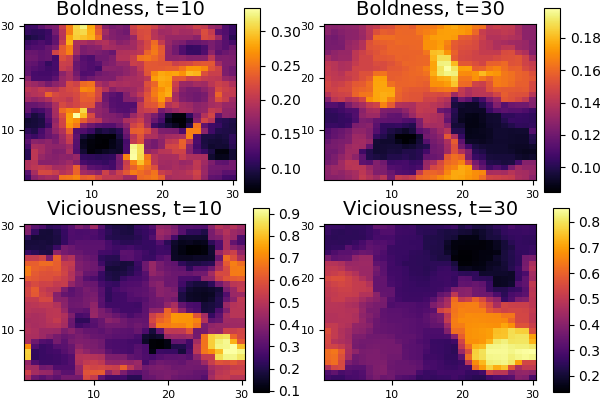

In [155]:
l = initialize_landscape(30, 30)

run_simulation(l, 10)
b1 = heatmap(map((a)->a.boldness, l), title="Boldness, t=10")
v1 = heatmap(map((a)->a.viciousness, l), title="Viciousness, t=10")
l_10 = deepcopy(l)

run_simulation(l, 20)
b2 = heatmap(map((a)->a.boldness, l), title="Boldness, t=30")
v2 = heatmap(map((a)->a.viciousness, l), title="Viciousness, t=30")
l_30 = deepcopy(l)

plot(b1,b2,v1,v2, layout=(2,2))


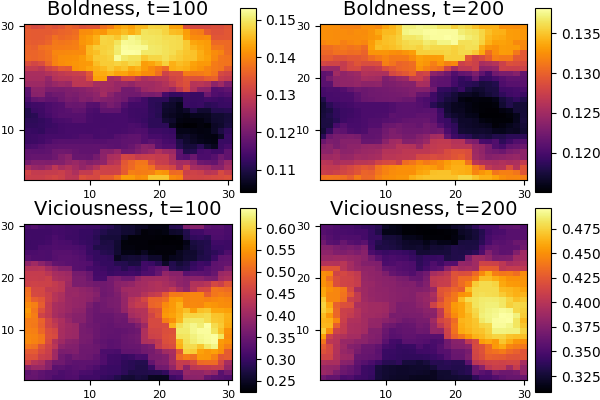

In [156]:
run_simulation(l, 70)
b3 = heatmap(map((a)->a.boldness, l), title="Boldness, t=100")
v3 = heatmap(map((a)->a.viciousness, l), title="Viciousness, t=100")
l_100 = deepcopy(l)

run_simulation(l, 100)
b4 = heatmap(map((a)->a.boldness, l), title="Boldness, t=200")
v4 = heatmap(map((a)->a.viciousness, l), title="Viciousness, t=200")
l_200 = deepcopy(l)

plot(b3,b4,v3,v4, layout=(2,2))

The above figure shows that over successive generations, regions of similar boldness/viciousness values consolidate and the extreme values of each variable grow closer together. There is also a rough relationship where higher values of boldness correspond to lower values of viciousness, and vice versa. This is shown in more depth in the scatterplot below. Starting from a uniform distribution, the agents converge on a progressively shrinking region of the strategy space. 


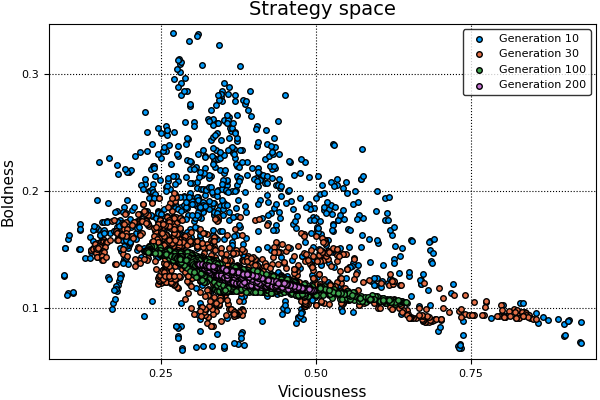

In [163]:
function plot_strategy_space(landscapes :: Array{Landscape,1}, gens :: Array{Int,1})
    
    samples = length(landscapes)
    agents = length(landscapes[1])

    bs = zeros(agents, samples)
    vs = zeros(agents, samples)
    
    for s = 1:samples
        bs[:,s] = reshape(map((a)->a.boldness, landscapes[s]), (agents,1))
        vs[:,s] = reshape(map((a)->a.viciousness, landscapes[s]), (agents,1))
    end
    
    labels = reshape(["Generation $i" for i=gens], (1,samples))
    return scatter(vs, bs, title="Strategy space", xlabel="Viciousness", ylabel="Boldness", label=labels)
end

plot_strategy_space([l_10, l_30, l_100, l_200], [10,30,100,200])


Intriguingly, even though our agents have evolved to all use a tiny subset of possible strategies, the distribution of payoffs at the end has barely improved, as depicted below. This suggests that model has not converged to a true minimum and that the fixed point is a random accident with no physical meaning. It might be more worthwhile to restart the simulation from the beginning many times and look for a pattern in the fixed points that emerge. One pattern that can already be seen from a single simulation run is a line running from (0.25,0.15) to (0.75,0.1).


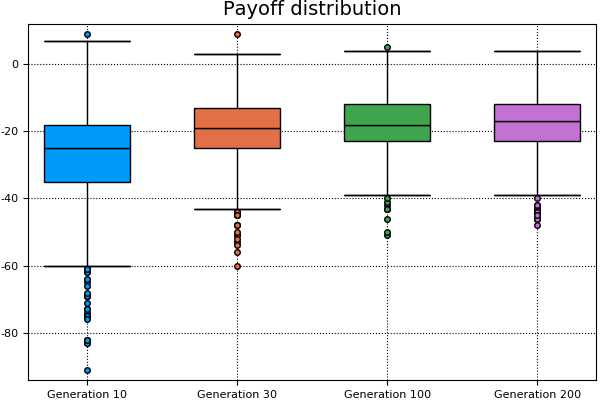

In [160]:
using StatPlots

function plot_payoff_distribution(landscapes :: Array{Landscape,1}, gens :: Array{Int,1})
    
    samples = length(landscapes)
    agents = length(landscapes[1])
    payoffs = zeros(agents, samples)
    
    for s = 1:samples
        payoffs[:,s] = reshape(map((a)->a.payoff, landscapes[s]), (agents,1))
    end
    
    labels = reshape(["Generation $i" for i=gens], (1,samples))
    return boxplot(labels, payoffs, title="Payoff distribution", leg=false)
end

plot_payoff_distribution([l_10, l_30, l_100, l_200], [10,30,100,200])
